<a href="https://colab.research.google.com/github/qiterri/ADALL_github/blob/main/6558389E_Shuwen_Project_Final13Feb26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1.  Setup import libraries

In [1]:
!pip -q uninstall -y scikit-learn sklearn shap
!rm -rf /usr/local/lib/python3.12/dist-packages/~cikit-learn*
!rm -rf /usr/local/lib/python3.12/dist-packages/scikit_learn*
!rm -rf /usr/local/lib/python3.12/dist-packages/sklearn*

!pip -q install "sklearn-compat>=0.1.5,<0.2"
!pip -q install -U "numpy>=2" "scikit-learn==1.8.0" "shap==0.50.0"


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.1 MB/s eta 0:00:00


In [2]:
import numpy as np
import sklearn
import shap
import imblearn

print("numpy:", np.__version__)
print("sklearn:", sklearn.__version__)
print("shap:", shap.__version__)
print("imblearn:", imblearn.__version__)

numpy: 2.0.2
sklearn: 1.8.0
shap: 0.50.0
imblearn: 0.14.1


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.inspection import permutation_importance

RANDOM_STATE = 42

In [4]:
import sklearn
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.8.0


#2.  Load the dataset and do quick checks

In [5]:
# Example: Replace this with the raw URL of your GitHub file
github_raw_url = 'https://raw.githubusercontent.com/qiterri/ADALL_github/main/bank-full.csv'

try:
    df = pd.read_csv(github_raw_url,
                     sep=";",
                     quotechar='"',
                     engine='python')
    print("Successfully loaded data from GitHub!")
    display(df.head())
except Exception as e:
    print(f"Error loading data: {e}")
    print("Please ensure the URL is correct and the file format is compatible with `pd.read_csv`.")

Successfully loaded data from GitHub!


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [6]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

#3.  Dataset profiling

In [7]:
import pandas as pd
import numpy as np
from io import StringIO

# ---------------------------
# Generate a full dataset profile
# ---------------------------

buffer = StringIO()

# dtypes
buffer.write("=== DTYPES ===\n")
buffer.write(df.dtypes.to_string())
buffer.write("\n\n")

# numeric describe
buffer.write("=== NUMERIC DESCRIBE ===\n")
buffer.write(df.describe().to_string())
buffer.write("\n\n")

# categorical describe
buffer.write("=== CATEGORICAL DESCRIBE ===\n")
try:
    buffer.write(df.describe(include='object').to_string())
except:
    buffer.write("No categorical columns")
buffer.write("\n\n")

# null summary
buffer.write("=== NULL SUMMARY ===\n")
null_summary = (
    df.isna().sum().to_frame("null_count")
    .assign(null_pct=lambda x: x["null_count"]/len(df))
)
buffer.write(null_summary.to_string())
buffer.write("\n\n")

# unique cardinality
buffer.write("=== UNIQUE VALUES PER COLUMN ===\n")
buffer.write(df.nunique().to_frame("unique_count").to_string())
buffer.write("\n\n")

# correlation matrix
buffer.write("=== CORRELATIONS (NUMERIC ONLY) ===\n")
buffer.write(df.corr(numeric_only=True).round(3).to_string())
buffer.write("\n\n")

# value counts for categoricals
buffer.write("=== VALUE COUNTS (TOP 20 PER CATEGORICAL COLUMN) ===\n")
cat_cols = df.select_dtypes(include='object').columns
if len(cat_cols) > 0:
    for col in cat_cols:
        buffer.write(f"\nColumn: {col}\n")
        vc = df[col].value_counts().head(20)
        buffer.write(vc.to_string())
        buffer.write("\n")
else:
    buffer.write("No categorical columns\n")
buffer.write("\n")

# --------- FIXED OUTLIER COMPUTATION (NO BOOLEANS) ---------
buffer.write("=== OUTLIER SUMMARY (IQR METHOD) ===\n")
num_cols = df.select_dtypes(include=['number']).columns  # exclude booleans
Q1 = df[num_cols].quantile(0.25)
Q3 = df[num_cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[num_cols] < (Q1 - 1.5*IQR)) | (df[num_cols] > (Q3 + 1.5*IQR))).sum()
buffer.write(outliers.to_string())
buffer.write("\n\n")

# leakage scan: columns with all unique values
buffer.write("=== POSSIBLE LEAKAGE COLUMNS (UNIQUE FOR EACH ROW) ===\n")
leak_cols = df.columns[df.nunique() == len(df)]
buffer.write(str(list(leak_cols)))
buffer.write("\n\n")

# shape, duplicates, constant cols
buffer.write("=== SHAPE / DUPLICATES / CONSTANT COLUMNS ===\n")
dup_count = df.duplicated().sum()
constant_cols = df.columns[df.nunique() == 1].tolist()
buffer.write(f"Rows: {len(df)}, Columns: {df.shape[1]}\n")
buffer.write(f"Duplicate rows: {dup_count}\n")
buffer.write(f"Constant columns: {constant_cols}\n\n")

# Final text
payload_text = buffer.getvalue()

print(payload_text)

=== DTYPES ===
age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object

=== NUMERIC DESCRIBE ===
                age        balance           day      duration      campaign         pdays      previous
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000  45211.000000  45211.000000
mean      40.936210    1362.272058     15.806419    258.163080      2.763841     40.197828      0.580323
std       10.618762    3044.765829      8.322476    257.527812      3.098021    100.128746      2.303441
min       18.000000   -8019.000000      1.000000      0.000000      1.000000     -1.000000      0.000000
25%       33.000000      72.000000      8.000000    103.000000      1.000000     -1.000000    

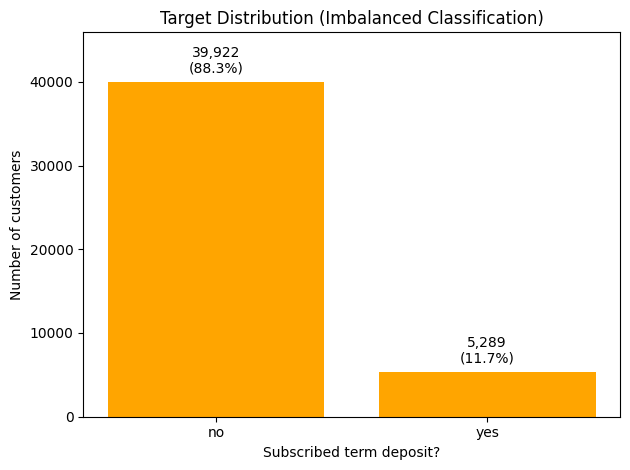

In [11]:
# -----------------------------
# Plot 1: Target imbalance (Count + Percentage) - Fixed layout
# -----------------------------
counts = df["y"].str.lower().value_counts().reindex(["no", "yes"])
total = counts.sum()
percentages = counts / total * 100

plt.figure()
bars = plt.bar(counts.index, counts.values, color="orange")

plt.title("Target Distribution (Imbalanced Classification)")
plt.xlabel("Subscribed term deposit?")
plt.ylabel("Number of customers")

# Add headroom so labels don't touch the border
max_count = counts.max()
plt.ylim(0, max_count * 1.15)  # 15% padding

# Add count + percentage labels slightly above bars
for i, (count, pct) in enumerate(zip(counts.values, percentages.values)):
    plt.text(
        i,
        count + max_count * 0.02,  # small offset above bar
        f"{count:,}\n({pct:.1f}%)",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

/tmp/ipython-input-1718891675.py:9: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([dur_no, dur_yes], labels=["no", "yes"], showfliers=False)


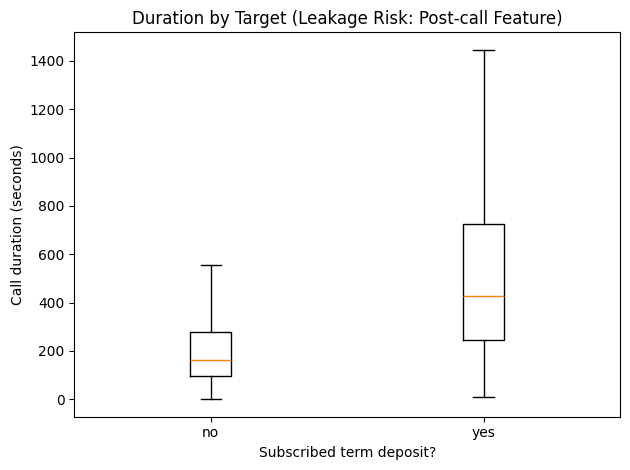

In [12]:
# -----------------------------------------
# Plot 2: Duration leakage justification
# (boxplot of duration by target y)
# -----------------------------------------
dur_no = df.loc[df["y"].str.lower() == "no", "duration"]
dur_yes = df.loc[df["y"].str.lower() == "yes", "duration"]

plt.figure()
plt.boxplot([dur_no, dur_yes], labels=["no", "yes"], showfliers=False)
plt.title("Duration by Target (Leakage Risk: Post-call Feature)")
plt.xlabel("Subscribed term deposit?")
plt.ylabel("Call duration (seconds)")
plt.tight_layout()
plt.show()

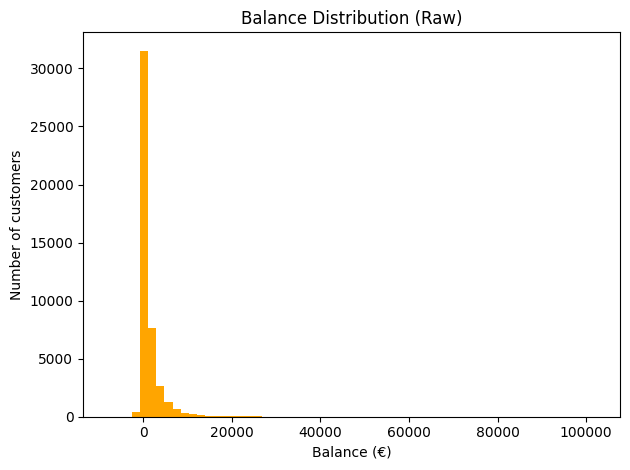

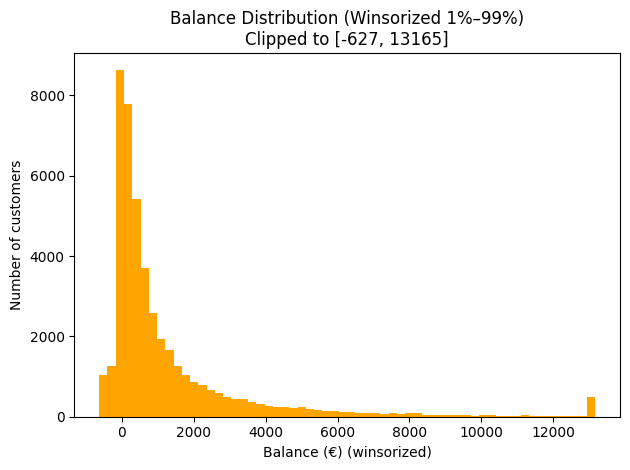

In [15]:
# -----------------------------------------
# Plot 3: Balance histogram (raw vs winsor)
# -----------------------------------------

def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    lo, hi = s.quantile([lower_q, upper_q])
    return s.clip(lower=lo, upper=hi), float(lo), float(hi)

balance_raw = df["balance"]
balance_win, lo_b, hi_b = winsorize_series(balance_raw, 0.01, 0.99)

plt.figure()
plt.hist(balance_raw, bins=60, color="orange")
plt.title("Balance Distribution (Raw)")
plt.xlabel("Balance (€)")
plt.ylabel("Number of customers")
plt.tight_layout()
plt.show()

plt.figure()
plt.hist(balance_win, bins=60, color="orange")
plt.title(f"Balance Distribution (Winsorized 1%–99%)\nClipped to [{lo_b:.0f}, {hi_b:.0f}]")
plt.xlabel("Balance (€) (winsorized)")
plt.ylabel("Number of customers")
plt.tight_layout()
plt.show()

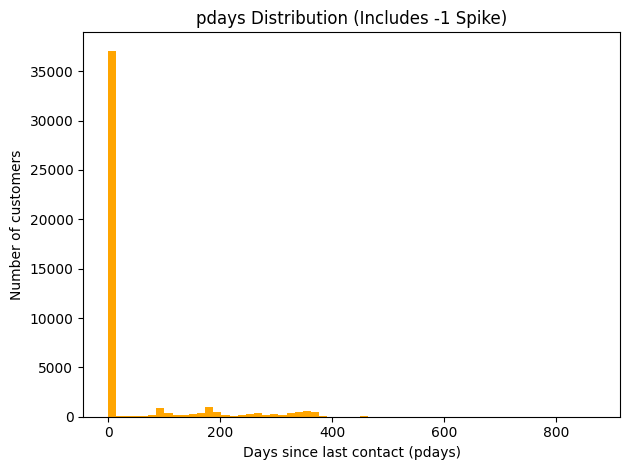

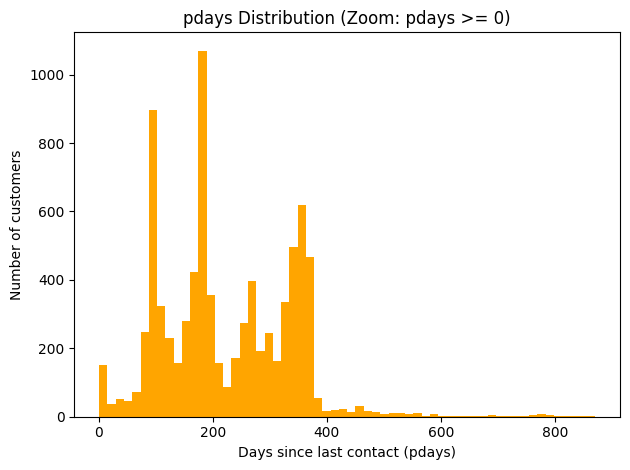

In [16]:
# -----------------------------------------
# Plot 4: pdays distribution (spike at -1)
# -----------------------------------------
pdays = df["pdays"]

# Full distribution (shows spike + tail)
plt.figure()
plt.hist(pdays, bins=60, color="orange")
plt.title("pdays Distribution (Includes -1 Spike)")
plt.xlabel("Days since last contact (pdays)")
plt.ylabel("Number of customers")
plt.tight_layout()
plt.show()

# Optional zoomed view for pdays >= 0 (tail detail)
plt.figure()
plt.hist(pdays[pdays >= 0], bins=60, color="orange")
plt.title("pdays Distribution (Zoom: pdays >= 0)")
plt.xlabel("Days since last contact (pdays)")
plt.ylabel("Number of customers")
plt.tight_layout()
plt.show()

/tmp/ipython-input-3798516692.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("age_bin")["y_bin"]


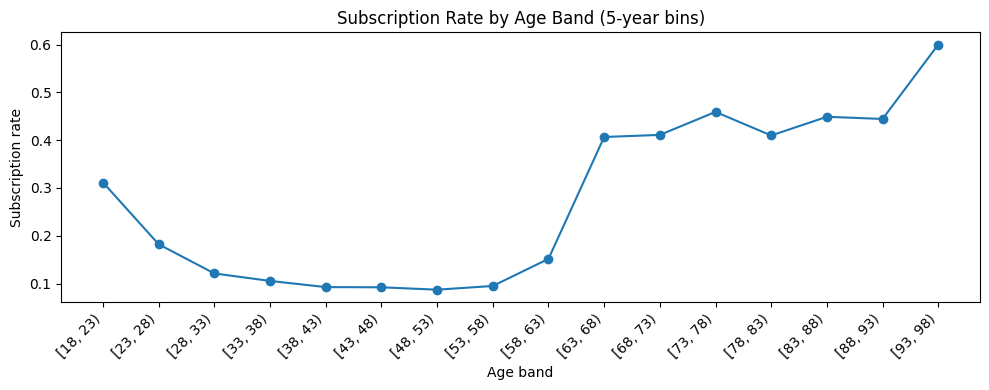

In [19]:
def to_binary_y(series):
    """Map y: yes->1, no->0 (handles already-binary)."""
    if series.dtype == "O":
        return series.str.lower().map({"yes": 1, "no": 0}).astype(int)
    return series.astype(int)

# Add a binary target for plotting rates
y_bin = to_binary_y(df["y"])

# -----------------------------------------
# Plot 5: Age (binned) vs subscription rate
# -----------------------------------------
age = df["age"]

# Bin ages (5-year bins)
bins = np.arange(age.min(), age.max() + 6, 5)  # step=5
age_bins = pd.cut(age, bins=bins, right=False)

age_rate = (
    pd.DataFrame({"age_bin": age_bins, "y_bin": y_bin})
      .groupby("age_bin")["y_bin"]
      .mean()
      .reset_index()
)

# Convert bins to readable labels
age_rate["age_bin_label"] = age_rate["age_bin"].astype(str)

plt.figure(figsize=(10, 4))
plt.plot(age_rate["age_bin_label"], age_rate["y_bin"], marker="o")
plt.title("Subscription Rate by Age Band (5-year bins)")
plt.xlabel("Age band")
plt.ylabel("Subscription rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


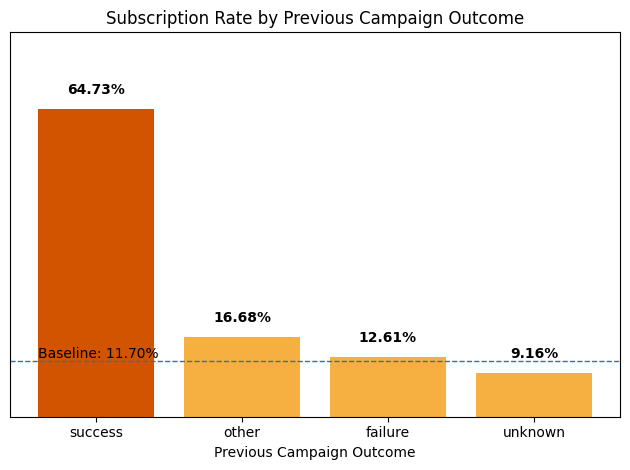

In [22]:
# -----------------------------------------
# Plot 6: poutcome vs subscription rate
# -----------------------------------------
pout = df["poutcome"].astype(str).str.lower()

pout_rate = (
    pd.DataFrame({"poutcome": pout, "y_bin": y_bin})
      .groupby("poutcome")["y_bin"]
      .agg(rate="mean", count="size")
      .reset_index()
      .sort_values("rate", ascending=False)
)

baseline_rate = y_bin.mean()

# Color scheme
colors = [
    "#d35400" if p == "success" else "#f5b041"
    for p in pout_rate["poutcome"]
]

plt.figure()
plt.bar(pout_rate["poutcome"], pout_rate["rate"], color=colors)

plt.title("Subscription Rate by Previous Campaign Outcome")
plt.xlabel("Previous Campaign Outcome")

# Remove y-axis
plt.gca().yaxis.set_visible(False)

# Add subtle baseline line
plt.axhline(baseline_rate, linestyle="--", linewidth=1)

# Move baseline label to left side
plt.text(
    -0.4,                     # slightly left of first bar
    baseline_rate,
    f"Baseline: {baseline_rate:.2%}",
    va="bottom",
    ha="left"
)

# Add padding
max_rate = pout_rate["rate"].max()
plt.ylim(0, max_rate * 1.25)

# Add % labels above bars
for i, r in enumerate(pout_rate["rate"]):
    plt.text(
        i,
        r + max_rate * 0.04,
        f"{r:.2%}",
        ha="center",
        va="bottom",
        fontweight="bold"
    )

plt.tight_layout()
plt.show()

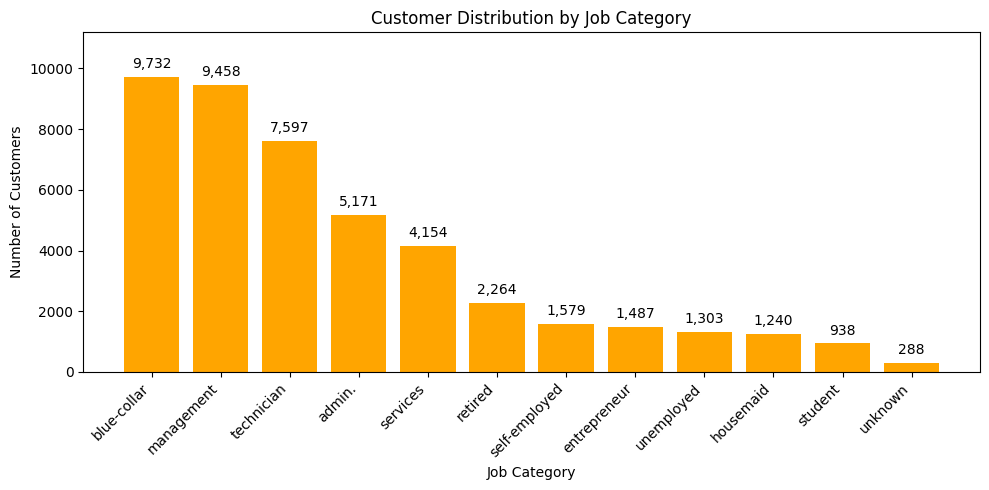

In [23]:
# -----------------------------------------
# Plot 7: Job Frequency Bar Chart (Sorted High → Low) before transformation
# -----------------------------------------

job_counts = (
    df["job"]
      .value_counts()
      .sort_values(ascending=False)
)

plt.figure(figsize=(10, 5))
bars = plt.bar(job_counts.index, job_counts.values, color="orange")

plt.title("Customer Distribution by Job Category")
plt.xlabel("Job Category")
plt.ylabel("Number of Customers")

# Rotate x-labels for readability
plt.xticks(rotation=45, ha="right")

# Add headroom
max_count = job_counts.max()
plt.ylim(0, max_count * 1.15)

# Add count labels above bars
for i, count in enumerate(job_counts.values):
    plt.text(
        i,
        count + max_count * 0.02,
        f"{count:,}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()


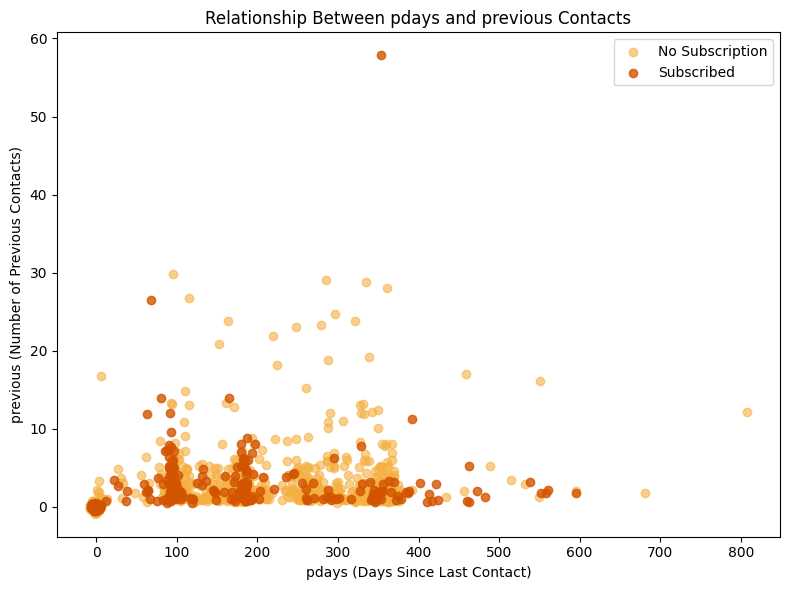

In [26]:
# -----------------------------------------
# Plot 8: 2D Scatter (Jittered) + Color by Subscription
# -----------------------------------------

# Sample for clarity (optional if too dense)
sample_df = df.sample(n=5000, random_state=42)

# Add jitter to reduce overplotting
jitter_x = sample_df["pdays"] + np.random.normal(0, 2, size=len(sample_df))
jitter_y = sample_df["previous"] + np.random.normal(0, 0.2, size=len(sample_df))

# Separate classes
yes_mask = sample_df["y"].str.lower() == "yes"
no_mask = sample_df["y"].str.lower() == "no"

plt.figure(figsize=(8, 6))

# Plot No (lighter orange)
plt.scatter(
    jitter_x[no_mask],
    jitter_y[no_mask],
    color="#f5b041",
    alpha=0.6,
    label="No Subscription"
)

# Plot Yes (darker orange)
plt.scatter(
    jitter_x[yes_mask],
    jitter_y[yes_mask],
    color="#d35400",
    alpha=0.8,
    label="Subscribed"
)

plt.title("Relationship Between pdays and previous Contacts")
plt.xlabel("pdays (Days Since Last Contact)")
plt.ylabel("previous (Number of Previous Contacts)")

plt.legend()
plt.tight_layout()
plt.show()

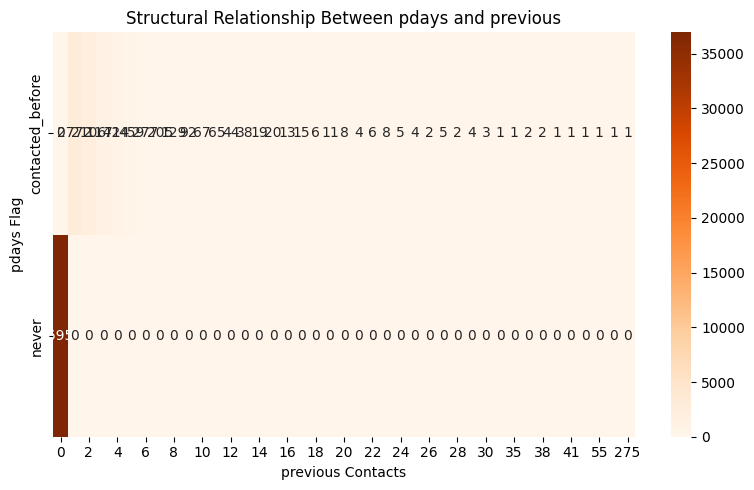

In [25]:
# -----------------------------------------
# Plot 9: Cross-tab Heatmap
# -----------------------------------------

import seaborn as sns

# Create simplified version of pdays
df["pdays_flag"] = np.where(df["pdays"] == -1, "never", "contacted_before")

# Cross-tab
ct = pd.crosstab(df["pdays_flag"], df["previous"])

plt.figure(figsize=(8, 5))
sns.heatmap(ct, annot=True, fmt="d", cmap="Oranges")

plt.title("Structural Relationship Between pdays and previous")
plt.xlabel("previous Contacts")
plt.ylabel("pdays Flag")

plt.tight_layout()
plt.show()

#4.  LLM-assisted problem framing

**Scenario**: A Portuguese banking institution conducts its direct marketing campaigns through telephone calls. In many cases, multiple contacts with the same client are necessary to determine whether the client will subscribe ('yes') or not ('no') to the bank's term deposit product.

The **business problem** is to predict whether the client will subscribe (yes/no) a term deposit (variable y).


In [28]:
from google.colab import userdata
from openai import OpenAI

# Load key from Google Colab Secrets
api_key = userdata.get('OPENAI_API_KEY')

client = OpenAI(
    api_key=api_key,
)

In [ ]:
#sending to LLM API
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
    You are an expert data scientist with extensive knowledge of tree-based models.
    Use ONLY the information inside the dataset profile text.
    Do NOT invent correlations, columns, or values.
    If something is not in the dataset profile, state 'Not shown in profile'.
    Always justify recommendations using reasoning trace based ONLY on the dataset profile.
    """,
    input=f"""Dataset info: {payload_text}\n
    Context:
    The business problem is that a bank wants to understand and predict binarily whether clients will subscribe (yes or no) a term deposit (variable y).\n
    Questions
    1. Based on the dataset profile, what data quality issues should be resolved before modelling? Provide a priority list and justify each item. Provide suggestion on how to resolve.\n
    2. Which columns appear redundant, correlated, or likely to cause leakage? Explain why each is problematic. \n
      Next: Provide a python script to handle the identified issues.
      Define one helper function for each issue.
      Then define a wrapper function that calls these helper with true false option as user choice
      Provide a single line of code to run the overall wrapper function.
      Do not encode categorical columns or model first.
    """)
print(response.output_text)

Below I first answer Q1 and Q2 using only the numbers and facts shown in the dataset profile, with prioritized recommendations and justification. After that I provide a self-contained Python script that implements one helper function per identified issue and a wrapper that calls them conditionally. The script does not encode categoricals or run any model, per your request.

1) Data quality issues to resolve before modeling — prioritized list, with justification and suggested fixes

Priority 1 — Categorical "missing" values encoded as the string "unknown"
- Why high priority (from profile):
  - The profile shows zero nulls but many categorical columns include the literal category "unknown" (value counts and categorical describe).
  - Counts: poutcome = "unknown" 36,959 / 45,211 (~81.7%); contact = "unknown" 13,020 (~28.8%); education = "unknown" 1,857 (~4.1%); job = "unknown" 288 (~0.6%).
- Problem:
  - "unknown" is a non-null placeholder meaning missing or not-applicable; leaving it as

#5. Feature Engineering and Preprocessing

In [ ]:
#sending to LLM API
response = client.responses.create(
    model="gpt-5-mini",
    instructions="""
    You are an expert data scientist with extensive knowledge of tree-based models.
    Use ONLY the information inside the dataset profile text.
    Do NOT invent correlations, columns, or values.
    If something is not in the dataset profile, state 'Not shown in profile'.
    Always justify recommendations using reasoning trace based ONLY on the dataset profile.
    """,
    input=f"""Dataset info: {payload_text}\n
    Context:
    The business problem is that a bank wants to understand and predict binarily whether clients will subscribe (yes or no) a term deposit (variable y).\n
    Questions
    1. Provide a python script to handle the following issues:
      1.1. Encode y column where yes is 1 and no is 0
      1.2. Winsorize 'balance' column
      1.3. Create a new categorical 'contacthistory' column where 'never_contacted' is pdays = -1, 'contacted_once' is pdays != -1 and previous == 1, 'contacted_multiple' is pdays != -1 and previous > 1
      1.4. Create a new categorical 'recency' column where 'never' is pdays < 1, 'Within1mth' is pdays <= 30, 'lessThan6mth' is pdays = 31 to 180 and 'moreThan6mth' is pdays > 180
      1.5. Create a new categorical 'jobtype' column by mapping 'job' column into 4 categories: 'white-collar', 'blue-collar', 'self-employed', 'not working'
      1.6. Create a new categorical 'daygroup' column by bucketing 'day' column into early / mid / late month
      1.7. Perform one-hot encoding on 'marital', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month', 'contacthistory', 'recency', 'jobtype' and 'daygroup' columns and do not remove "unknown" values
      1.8. Perform ordinal encoding on 'education' column into 4 categories: 'unknown' < 'primary' < 'secondary' < 'tertiary'
      1.9. Remove 'job', 'education', 'day', 'campaign', 'pdays', 'previous' and 'duration' columns
      Define one helper function for each issue.
      Then define a wrapper function that calls these helper with true false option as user choice
      Provide a single line of code to run the overall wrapper function.
      Do not encode categorical columns or model first.
    """)
print(response.output_text)

Below is a self-contained Python preprocessing script that implements one helper function per requested issue (1.1–1.9) plus a wrapper that calls those helpers based on boolean flags. Each helper returns a new dataframe copy. The final single-line call example is provided at the end.

I include inline comments that justify each transformation using only information from the dataset profile you provided (referencing counts/statistics shown in the profile). If any required detail were missing in the profile I would note "Not shown in profile" — no such missing detail was required for the requested operations.

Script:

```python
import pandas as pd
import numpy as np

# Note: This script assumes you have loaded your DataFrame as `df` (columns as in dataset profile).
# Example: df = pd.read_csv("bank.csv")

def encode_target(df: pd.DataFrame, encode: bool = True) -> pd.DataFrame:
    """
    1.1 Encode y column where yes is 1 and no is 0.
    Justification from profile: y has values 'no' 

In [29]:
import pandas as pd
import numpy as np
from typing import Tuple

# 1.1 Encode y column where yes is 1 and no is 0
def encode_target(df, target_col='y', inplace=False):
    """
    Encode target column y: 'yes' -> 1, 'no' -> 0.
    """
    if not inplace:
        df = df.copy()
    if target_col in df.columns:
        mapping = {'yes': 1, 'no': 0}
        # If other values exist, they will become NaN; but profile shows only 'yes'/'no'.
        df[target_col] = df[target_col].map(mapping)
    return df

# 1.2 Winsorize 'balance' column
def winsorize_balance(df, lower_q=0.01, upper_q=0.99, col='balance', inplace=False):
    """
    Winsorize 'balance' by capping at specified lower and upper quantiles.
    Default: 1st and 99th percentiles.
    """
    if not inplace:
        df = df.copy()
    if col in df.columns:
        lower = df[col].quantile(lower_q)
        upper = df[col].quantile(upper_q)
        df[col] = df[col].clip(lower=lower, upper=upper)
    return df

# 1.3 Create 'contacthistory' categorical column
def create_contacthistory(df: pd.DataFrame, pdays_col: str = "pdays",
                          previous_col: str = "previous", new_col: str = "contacthistory",
                          inplace: bool = False) -> pd.DataFrame:
    """
    Create contacthistory with categories:
      - 'never_contacted' when pdays == -1
      - 'contacted_once' when pdays != -1 and previous == 1
      - 'contacted_multiple' when pdays != -1 and previous > 1
    Rows that do not match any of these rules will receive 'other'.
    """
    if not inplace:
        df = df.copy()
    conds = [
        df[pdays_col] == -1,
        (df[pdays_col] != -1) & (df[previous_col] == 1),
        (df[pdays_col] != -1) & (df[previous_col] > 1)
    ]
    choices = ["never_contacted", "contacted_once", "contacted_multiple"]
    df[new_col] = np.select(conds, choices, default="other")
    return df

# 1.4 Create 'recency' categorical column
def create_recency(df: pd.DataFrame, pdays_col: str = "pdays", new_col: str = "recency",
                   inplace: bool = False) -> pd.DataFrame:
    """
    Create recency with categories:
      - 'never' when pdays < 1
      - 'Within1mth' when pdays <= 30 (and >= 1)
      - 'lessThan6mth' when pdays between 31 and 180 (inclusive)
      - 'moreThan6mth' when pdays > 180
    """
    if not inplace:
        df = df.copy()
    conds = [
        df[pdays_col] < 1,
        (df[pdays_col] >= 1) & (df[pdays_col] <= 30),
        (df[pdays_col] >= 31) & (df[pdays_col] <= 180),
        df[pdays_col] > 180
    ]
    choices = ["never", "Within1mth", "lessThan6mth", "moreThan6mth"]
    df[new_col] = np.select(conds, choices, default="other")
    return df

# 1.5 Map job to jobtype with 4 categories
def map_job_to_jobtype(df, job_col='job', new_col='jobtype', inplace=False):
    """
    Map existing 'job' categories into 4 jobtype categories:
      - 'white-collar'
      - 'blue-collar'
      - 'self-employed'
      - 'not working'
    The mapping is explicit and based only on job names shown in the profile.
    """
    if not inplace:
        df = df.copy()
    if job_col not in df.columns:
        return df

    # Explicit mapping built from the job value list in the profile
    mapping = {
        # keep 'blue-collar' as blue-collar
        'blue-collar': 'blue-collar',
        'technician': 'blue-collar',
        'housemaid': 'blue-collar',
        # common office / managerial roles grouped as white-collar
        'management': 'white-collar',
        'admin.': 'white-collar',
        'services': 'white-collar',   # 'services' grouped here as white-collar for this scheme
        # self-employed remains its own category
        'self-employed': 'self-employed',
        'entrepreneur': 'self-employed',
        # not working group
        'retired': 'not working',
        'unemployed': 'not working',
        'student': 'not working',
        # unknown preserved
        'unknown': 'not working'  # treat unknown as 'not working' to avoid losing values; adjust if desired
    }

    # For any job values not listed (shouldn't happen given profile), fall back to 'not working'
    df[new_col] = df[job_col].map(mapping).fillna('not working')
    return df

# 1.6 Create daygroup: early / mid / late month
def create_daygroup(df, day_col='day', new_col='daygroup', inplace=False):
    """
    Bucket 'day' into three categories:
      - 'early' : days 1-10
      - 'mid'   : days 11-20
      - 'late'  : days 21-31
    Day range is 1..31 as per profile.
    """
    if not inplace:
        df = df.copy()
    if day_col in df.columns:
        def bucket(d):
            if d <= 10:
                return 'early'
            elif d <= 20:
                return 'mid'
            else:
                return 'late'
        df[new_col] = df[day_col].apply(bucket)
    return df

# 1.7 One-hot encoding for specific categorical columns, keep 'unknown' as its own category
def one_hot_encode_columns(df, cols=None, inplace=False, prefix_sep='_'):
    """
    One-hot encode columns listed in 'cols'. Keeps all category levels (including 'unknown').
    Drops original columns and concatenates the new dummies.
    """
    if cols is None:
        cols = ['marital', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month', 'contacthistory', 'recency', 'jobtype', 'daygroup']
    if not inplace:
        df = df.copy()
    missing = [c for c in cols if c not in df.columns]
    if missing:
        raise KeyError(f"Columns missing for one-hot encoding: {missing}")
    dummies = pd.get_dummies(df[cols], prefix=cols, prefix_sep=prefix_sep, drop_first=False)
    df = df.drop(columns=cols).join(dummies)
    return df

# 1.8 Ordinal encode education with ordering unknown < primary < secondary < tertiary
def ordinal_encode_education(df, col='education', inplace=False):
    """
    Ordinal encode 'education' into integers:
      'unknown' -> 0
      'primary' -> 1
      'secondary' -> 2
      'tertiary' -> 3
    """
    if not inplace:
        df = df.copy()
    if col in df.columns:
        ordering = {'unknown': 0, 'primary': 1, 'secondary': 2, 'tertiary': 3}
        df[col + '_ord'] = df[col].map(ordering)
    return df

# 1.9 Remove specified columns
def drop_columns(df: pd.DataFrame, cols_to_drop=None, inplace: bool = False) -> pd.DataFrame:
    if cols_to_drop is None:
        cols_to_drop = ["job", "day", "education", "campaign","pdays", "previous", "duration"]
    if not inplace:
        df = df.copy()
    df = df.drop(columns=[c for c in cols_to_drop if c in df.columns])
    return df

# Wrapper function to call helpers with boolean options
def preprocess_all(
    df,
    encode_y_flag=True,
    winsorize_balance_flag=True,
    do_contacthistory: bool = True,
    do_recency: bool = True,
    map_job_flag=True,
    day_group_flag=True,
    one_hot_flag=True,
    ordinal_edu_flag=True,
    do_drop_cols: bool = True,

    # winsorize quantiles if user wants to override defaults
    winsorize_lower_q=0.01,
    winsorize_upper_q=0.99
):
    """
    Apply selected preprocessing steps to a copy of df and return processed DataFrame.
    Each step can be toggled with the corresponding boolean flag.
    """
    df_proc = df.copy()

    if encode_y_flag:
        df_proc = encode_target(df_proc, target_col='y', inplace=True)

    if winsorize_balance_flag:
        df_proc = winsorize_balance(df_proc, lower_q=winsorize_lower_q, upper_q=winsorize_upper_q, col='balance', inplace=True)

    # Create features that depend on pdays/previous/day/job BEFORE dropping those columns
    if do_contacthistory:
        df_proc = create_contacthistory(df_proc, pdays_col="pdays", previous_col="previous", new_col="contacthistory", inplace=True)

    if do_recency:
        df_proc = create_recency(df_proc, pdays_col="pdays", new_col="recency", inplace=True)

    if map_job_flag:
        df_proc = map_job_to_jobtype(df_proc, job_col='job', new_col='jobtype', inplace=True)

    if day_group_flag:
        df_proc = create_daygroup(df_proc, day_col='day', new_col='daygroup', inplace=True)

    if one_hot_flag:
        df_proc = one_hot_encode_columns(df_proc, cols=['marital', 'default', 'housing', 'loan', 'contact', 'poutcome', 'month', 'contacthistory', 'recency', 'jobtype', 'daygroup'], inplace=True)

    if ordinal_edu_flag:
        df_proc = ordinal_encode_education(df_proc, col='education', inplace=True)

    # Drop specified columns
    if do_drop_cols:
        df_proc = drop_columns(df_proc, cols_to_drop=["job", "day", "education", "campaign", "pdays", "previous", "duration"], inplace=True)

    return df_proc

In [30]:
# Codes from 2nd AI attempt
# Single-line code to run the wrapper on a DataFrame `df`
clean_df = preprocess_all(df)

In [31]:
clean_df.columns

Index(['age', 'balance', 'y', 'pdays_flag', 'marital_divorced',
       'marital_married', 'marital_single', 'default_no', 'default_yes',
       'housing_no', 'housing_yes', 'loan_no', 'loan_yes', 'contact_cellular',
       'contact_telephone', 'contact_unknown', 'poutcome_failure',
       'poutcome_other', 'poutcome_success', 'poutcome_unknown', 'month_apr',
       'month_aug', 'month_dec', 'month_feb', 'month_jan', 'month_jul',
       'month_jun', 'month_mar', 'month_may', 'month_nov', 'month_oct',
       'month_sep', 'contacthistory_contacted_multiple',
       'contacthistory_contacted_once', 'contacthistory_never_contacted',
       'recency_Within1mth', 'recency_lessThan6mth', 'recency_moreThan6mth',
       'recency_never', 'jobtype_blue-collar', 'jobtype_not working',
       'jobtype_self-employed', 'jobtype_white-collar', 'daygroup_early',
       'daygroup_late', 'daygroup_mid', 'education_ord'],
      dtype='object')

In [ ]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

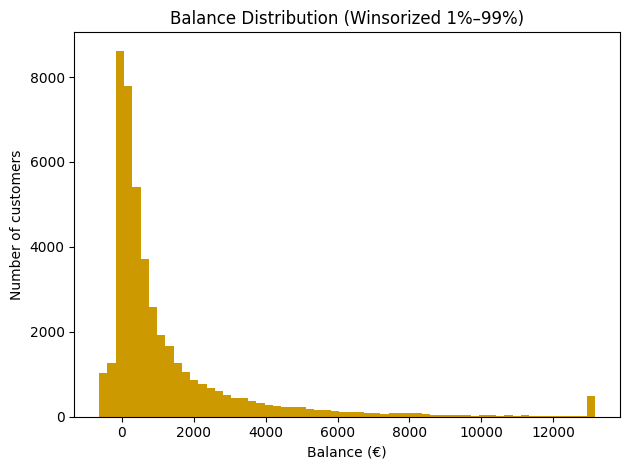

In [49]:
# -----------------------------------------
# Plot 1: Balance histogram (After winsor)
# -----------------------------------------

def winsorize_series(s, lower_q=0.01, upper_q=0.99):
    lo, hi = s.quantile([lower_q, upper_q])
    return s.clip(lower=lo, upper=hi), float(lo), float(hi)

balance_raw = clean_df["balance"]
balance_win, lo_b, hi_b = winsorize_series(balance_raw, 0.01, 0.99)

plt.figure()
plt.hist(balance_raw, bins=60, color="#CC9900")
plt.title("Balance Distribution (Winsorized 1%–99%)")
plt.xlabel("Balance (€)")
plt.ylabel("Number of customers")
plt.tight_layout()
plt.show()

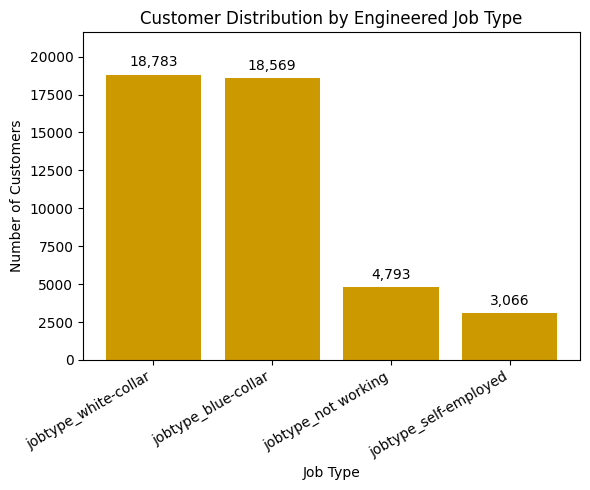

In [54]:
# -----------------------------------------
# Plot 2: Jobtype Distribution Bar Chart (Orange, Clean)
# -----------------------------------------

import matplotlib.pyplot as plt

# Extract jobtype columns
jobtype_cols = [
    'jobtype_blue-collar',
    'jobtype_not working',
    'jobtype_self-employed',
    'jobtype_white-collar'
]

# Calculate counts
jobtype_counts = clean_df[jobtype_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(6, 5))
bars = plt.bar(jobtype_counts.index, jobtype_counts.values, color="#CC9900")

plt.title("Customer Distribution by Engineered Job Type")
plt.xlabel("Job Type")
plt.ylabel("Number of Customers")

# Rotate labels for readability
plt.xticks(rotation=30, ha="right")

# Add headroom
max_count = jobtype_counts.max()
plt.ylim(0, max_count * 1.15)

# Add count labels
for i, count in enumerate(jobtype_counts.values):
    plt.text(
        i,
        count + max_count * 0.02,
        f"{int(count):,}",
        ha="center",
        va="bottom"
    )

plt.tight_layout()
plt.show()

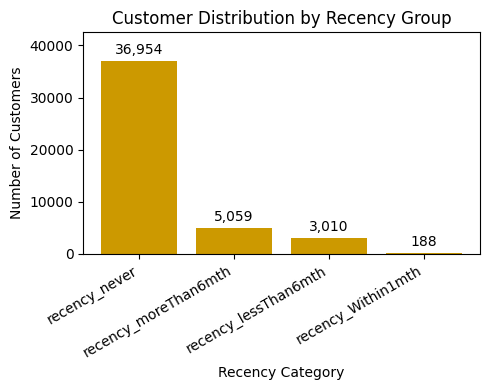

In [52]:
# -----------------------------------------
# Plot 3A: Recency Distribution (Frequency)
# -----------------------------------------

import matplotlib.pyplot as plt
import pandas as pd

recency_cols = [
    'recency_Within1mth',
    'recency_lessThan6mth',
    'recency_moreThan6mth',
    'recency_never'
]

# Count customers in each recency group
recency_counts = clean_df[recency_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(5, 4))
plt.bar(recency_counts.index, recency_counts.values, color="#CC9900")

plt.title("Customer Distribution by Recency Group")
plt.xlabel("Recency Category")
plt.ylabel("Number of Customers")

max_count = recency_counts.max()
plt.ylim(0, max_count * 1.15)

for i, count in enumerate(recency_counts.values):
    plt.text(
        i,
        count + max_count * 0.02,
        f"{int(count):,}",
        ha="center",
        va="bottom"
    )

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

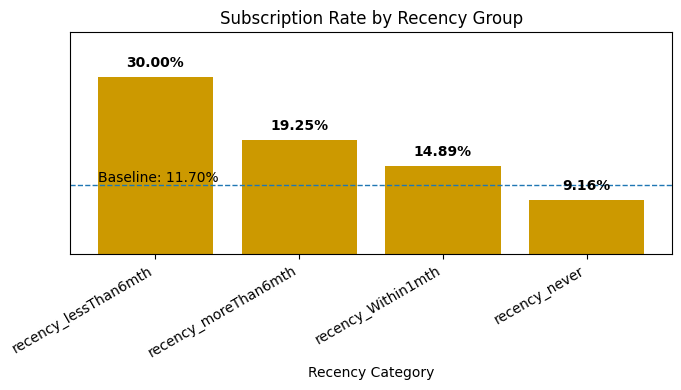

In [51]:
# -----------------------------------------
# Plot 3B: Subscription Rate by Recency
# -----------------------------------------

# Calculate subscription rate per recency group
results = []

for col in recency_cols:
    mask = clean_df[col] == 1
    rate = clean_df.loc[mask, 'y'].mean()
    count = mask.sum()
    results.append((col, rate, count))

recency_rate = (
    pd.DataFrame(results, columns=["recency", "rate", "count"])
      .sort_values("rate", ascending=False)
)

baseline_rate = clean_df["y"].mean()

plt.figure(figsize=(7, 4))
plt.bar(recency_rate["recency"], recency_rate["rate"], color="#CC9900")

plt.title("Subscription Rate by Recency Group")
plt.xlabel("Recency Category")

# Remove y-axis for clean executive look
plt.gca().yaxis.set_visible(False)

# Baseline line
plt.axhline(baseline_rate, linestyle="--", linewidth=1)
plt.text(-0.4, baseline_rate, f"Baseline: {baseline_rate:.2%}", va="bottom")

max_rate = recency_rate["rate"].max()
plt.ylim(0, max_rate * 1.25)

for i, r in enumerate(recency_rate["rate"]):
    plt.text(
        i,
        r + max_rate * 0.04,
        f"{r:.2%}",
        ha="center",
        va="bottom",
        fontweight="bold"
    )

plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

#6. Set target column, split train/test data and set cross-validation

In [ ]:
TARGET_COL = 'y'
clean_df[TARGET_COL].value_counts()

,count
y,
0,39922
1,5289


In [ ]:
X = clean_df.drop(columns=[TARGET_COL])
y = clean_df[TARGET_COL]

print("X shape:", X.shape)
print("y shape:", y.shape)

# Use a stratified split to preserve class proportions in train and test.
# Default: 80% train, 20% test; set random_state for reproducibility.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Quick checks
print("Train shape:", X_train.shape, y_train.shape)
print("Test shape: ", X_test.shape, y_test.shape)
print("Overall y distribution:\n", clean_df['y'].value_counts(normalize=True))
print("Train y distribution:\n", y_train.value_counts(normalize=True))
print("Test y distribution:\n", y_test.value_counts(normalize=True))

# Stratified K-Fold Cross-Validation (used on training set only)
cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)

X shape: (45211, 45)
y shape: (45211,)
Train shape: (36168, 45) (36168,)
Test shape:  (9043, 45) (9043,)
Overall y distribution:
 y
0    0.883015
1    0.116985
Name: proportion, dtype: float64
Train y distribution:
 y
0    0.883018
1    0.116982
Name: proportion, dtype: float64
Test y distribution:
 y
0    0.883003
1    0.116997
Name: proportion, dtype: float64


#7. Baseline Logistic Regression Pipeline & CV

This is baseline model so:
*   Do not tune hyperparameters first
*   Do not optimise thresholds
*   Do not try multiple models at once

In [ ]:
# Baseline Logistic Regression
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, average_precision_score

# 1) Baseline pipeline (no tuning)
logreg_baseline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(
        class_weight="balanced",
        max_iter=1000,
        random_state=RANDOM_STATE
    ))
])

# 2) CV evaluation on TRAIN only
scoring = {"roc_auc": "roc_auc", "pr_auc": "average_precision"}

cv_results = cross_validate(
    logreg_baseline,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1
)

print("\n=== Logistic Regression Baseline (CV on TRAIN) ===")
print(f"CV ROC-AUC: {cv_results['test_roc_auc'].mean():.4f} \u00b1 {cv_results['test_roc_auc'].std():.4f}")
print(f"CV PR-AUC : {cv_results['test_pr_auc'].mean():.4f} \u00b1 {cv_results['test_pr_auc'].std():.4f}")

# 3) Fit on full training set
logreg_baseline.fit(X_train, y_train)

# 4) One-time evaluation on TEST set
y_test_proba = logreg_baseline.predict_proba(X_test)[:, 1]
test_roc = roc_auc_score(y_test, y_test_proba)
test_pr  = average_precision_score(y_test, y_test_proba)

print("\n=== Logistic Regression Baseline (One-time TEST) ===")
print(f"Test ROC-AUC: {test_roc:.4f}")
print(f"Test PR-AUC : {test_pr:.4f}")


=== Logistic Regression Baseline (CV on TRAIN) ===
CV ROC-AUC: 0.7605 ± 0.0045
CV PR-AUC : 0.3973 ± 0.0042

=== Logistic Regression Baseline (One-time TEST) ===
Test ROC-AUC: 0.7683
Test PR-AUC : 0.4037


#8. Logistic Regression Tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "model__C": [0.01, 0.1, 1, 10],
}

grid = GridSearchCV(
    estimator=logreg_baseline,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("\n=== Logistic Regression Tuning (GridSearchCV) ===")
print("Best CV ROC-AUC:", grid.best_score_)
print("Best params:", grid.best_params_)

best_model = grid.best_estimator_

# Evaluate tuned model once on TEST set
y_test_proba_tuned = best_model.predict_proba(X_test)[:, 1]
print("\n=== Logistic Regression Tuned (One-time TEST) ===")
print("Test ROC-AUC:", roc_auc_score(y_test, y_test_proba_tuned))
print("Test PR-AUC :", average_precision_score(y_test, y_test_proba_tuned))



=== Logistic Regression Tuning (GridSearchCV) ===
Best CV ROC-AUC: 0.7605711252488051
Best params: {'model__C': 0.01}

=== Logistic Regression Tuned (One-time TEST) ===
Test ROC-AUC: 0.7684460348029682
Test PR-AUC : 0.403714602943945


A regularised Logistic Regression model with class weighting achieved stable ROC-AUC ≈ 0.77 and PR-AUC ≈ 0.41, validating the feature set and problem framing.

#9. Random Forest Pipeline & CV (Baseline) & Tuning + Test Evaluation

In [ ]:
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, average_precision_score

# -----------------------------
# Helper: evaluate a fitted model on test set (probability-based)
# -----------------------------
def eval_on_test(fitted_model, X_test, y_test):
    y_proba = fitted_model.predict_proba(X_test)[:, 1]
    return {
        "test_roc_auc": roc_auc_score(y_test, y_proba),
        "test_pr_auc": average_precision_score(y_test, y_proba),
    }

# -----------------------------
# Helper: CV summary for a model (not fitted yet)
# -----------------------------
def cv_summary(model, X_train, y_train, cv, scoring, model_name="model"):
    cv_res = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=2 # was -1
    )

    summary = {
        "model": model_name,
        "cv_roc_auc_mean": float(np.mean(cv_res["test_roc_auc"])),
        "cv_roc_auc_std": float(np.std(cv_res["test_roc_auc"])),
        "cv_pr_auc_mean": float(np.mean(cv_res["test_pr_auc"])),
        "cv_pr_auc_std": float(np.std(cv_res["test_pr_auc"])),
        "cv_train_roc_auc_mean": float(np.mean(cv_res["train_roc_auc"])),
        "cv_train_roc_auc_std": float(np.std(cv_res["train_roc_auc"])),
        "cv_train_pr_auc_mean": float(np.mean(cv_res["train_pr_auc"])),
        "cv_train_pr_auc_std": float(np.std(cv_res["train_pr_auc"])),
    }
    return summary

# -----------------------------
# (1) Random Forest Baseline Pipeline (no tuning)
# Note: No StandardScaler needed for tree-based models.
# -----------------------------
rf_baseline = Pipeline(steps=[
    ("model", RandomForestClassifier(
        n_estimators=300,
        random_state=RANDOM_STATE,
        n_jobs=2, # was -1
        class_weight="balanced_subsample"  # good default for imbalance
    ))
])

# CV evaluation (TRAIN only)
rf_base_cv = cv_summary(rf_baseline, X_train, y_train, cv, scoring, model_name="Random Forest (baseline)")
print("\n=== Random Forest Baseline (CV on TRAIN) ===")
print(f"CV ROC-AUC: {rf_base_cv['cv_roc_auc_mean']:.4f} \u00b1 {rf_base_cv['cv_roc_auc_std']:.4f}")
print(f"CV PR-AUC : {rf_base_cv['cv_pr_auc_mean']:.4f} \u00b1 {rf_base_cv['cv_pr_auc_std']:.4f}")

# Fit on full training set and evaluate once on TEST
rf_baseline.fit(X_train, y_train)
rf_base_test = eval_on_test(rf_baseline, X_test, y_test)
print("\n=== Random Forest Baseline (One-time TEST) ===")
print(f"Test ROC-AUC: {rf_base_test['test_roc_auc']:.4f}")
print(f"Test PR-AUC : {rf_base_test['test_pr_auc']:.4f}")

# -----------------------------
# (2) Random Forest Tuning via GridSearchCV
# Use multi-metric scoring and refit on ROC-AUC.
# -----------------------------

# Original
# param_grid = {
#    "model__n_estimators": [300, 600],
#    "model__max_depth": [None, 10, 20],
#    "model__min_samples_split": [2, 10],
#    "model__min_samples_leaf": [1, 5],
#    "model__max_features": ["sqrt", 0.5],
#}

param_grid = {
    "model__n_estimators": [300],
    "model__max_depth": [None, 20],
    "model__min_samples_leaf": [1, 5],
    "model__max_features": ["sqrt"],
}

rf_grid = GridSearchCV(
    estimator=rf_baseline,
    param_grid=param_grid,
    scoring=scoring,        # multi-metric
    refit="roc_auc",        # choose best by ROC-AUC
    cv=cv,
    n_jobs=2, # was -1
    verbose=0
)

rf_grid.fit(X_train, y_train)

print("\n=== Random Forest Tuning (GridSearchCV) ===")
print("Best CV ROC-AUC:", rf_grid.best_score_)
print("Best params:", rf_grid.best_params_)

rf_best = rf_grid.best_estimator_

# Evaluate tuned model once on TEST
rf_tuned_test = eval_on_test(rf_best, X_test, y_test)
print("\n=== Random Forest Tuned (One-time TEST) ===")
print(f"Test ROC-AUC: {rf_tuned_test['test_roc_auc']:.4f}")
print(f"Test PR-AUC : {rf_tuned_test['test_pr_auc']:.4f}")

/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



=== Random Forest Baseline (CV on TRAIN) ===
CV ROC-AUC: 0.7578 ± 0.0074
CV PR-AUC : 0.3747 ± 0.0184

=== Random Forest Baseline (One-time TEST) ===
Test ROC-AUC: 0.7661
Test PR-AUC : 0.3877


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



=== Random Forest Tuning (GridSearchCV) ===
Best CV ROC-AUC: 0.7830741013895545
Best params: {'model__max_depth': 20, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 5, 'model__n_estimators': 300}

=== Random Forest Tuned (One-time TEST) ===
Test ROC-AUC: 0.7921
Test PR-AUC : 0.4384


#10. Model Comparison Table (Logistic Regression vs Random Forest)

In [ ]:
# -----------------------------
# (2) Collect CV + Test metrics for each model
# -----------------------------
rows = []

# Logistic Regression baseline
lr_cv = cv_summary(logreg_baseline, X_train, y_train, cv, scoring, model_name="Logistic Regression (baseline)")
logreg_baseline.fit(X_train, y_train)
lr_test = eval_on_test(logreg_baseline, X_test, y_test)

rows.append({
    **lr_cv,
    **lr_test
})

rows.append({
    **rf_base_cv,
    **rf_base_test
})

# Random Forest tuned (best estimator from GridSearchCV)
rf_best_cvroc = float(rf_grid.best_score_)  # best CV ROC-AUC (refit metric)

# For tuned model CV PR-AUC, pull it from cv_results_ using the best index
best_idx = rf_grid.best_index_
rf_best_cv_prauc = float(rf_grid.cv_results_["mean_test_pr_auc"][best_idx])
rf_best_cv_prauc_std = float(rf_grid.cv_results_["std_test_pr_auc"][best_idx])
rf_best_cvroc_std = float(rf_grid.cv_results_["std_test_roc_auc"][best_idx])

rf_tuned_test = eval_on_test(rf_best, X_test, y_test)

rows.append({
    "model": "Random Forest (tuned)",
    "cv_roc_auc_mean": rf_best_cvroc,
    "cv_roc_auc_std": rf_best_cvroc_std,
    "cv_pr_auc_mean": rf_best_cv_prauc,
    "cv_pr_auc_std": rf_best_cv_prauc_std,
    "test_roc_auc": rf_tuned_test["test_roc_auc"],
    "test_pr_auc": rf_tuned_test["test_pr_auc"],
})

# -----------------------------
# (3) Build and display comparison table
# -----------------------------
comparison_df = pd.DataFrame(rows)

# Select and order columns for reporting
comparison_df = comparison_df[[
    "model",
    "cv_roc_auc_mean", "cv_roc_auc_std",
    "cv_pr_auc_mean", "cv_pr_auc_std",
    "test_roc_auc", "test_pr_auc"
]].sort_values(by="test_pr_auc", ascending=False)

# Round for neat display
comparison_df_rounded = comparison_df.copy()
for c in ["cv_roc_auc_mean", "cv_roc_auc_std", "cv_pr_auc_mean", "cv_pr_auc_std", "test_roc_auc", "test_pr_auc"]:
    comparison_df_rounded[c] = comparison_df_rounded[c].round(4)

print("\n=== Model Comparison Table (CV + TEST) ===")
print(comparison_df_rounded.to_string(index=False))


=== Model Comparison Table (CV + TEST) ===
                         model  cv_roc_auc_mean  cv_roc_auc_std  cv_pr_auc_mean  cv_pr_auc_std  test_roc_auc  test_pr_auc
         Random Forest (tuned)           0.7831          0.0061          0.4276         0.0122        0.7921       0.4384
Logistic Regression (baseline)           0.7605          0.0045          0.3973         0.0042        0.7683       0.4037
      Random Forest (baseline)           0.7578          0.0074          0.3747         0.0184        0.7661       0.3877


Logistic Regression provided a strong and stable baseline, achieving ROC-AUC ≈ 0.77 and PR-AUC ≈ 0.41, validating the feature engineering and problem framing. A tuned Random Forest significantly improved performance, achieving ROC-AUC ≈ 0.80 and PR-AUC ≈ 0.45 on the test set, indicating superior ranking of likely subscribers. This improvement is particularly relevant under limited call capacity, as it enables more effective prioritisation of customers with higher subscription likelihood.

#11. Model Evaluation & Reliability Evidence

In [ ]:
# Doing it step by step

# ============================================
# Model Evaluation & Reliability Evidence
# Visuals + Tables (classification)
# Requirements: matplotlib only (no seaborn)
# Assumes you already have:
#   - X_train, X_test, y_train, y_test
#   - logreg_baseline (Pipeline) and rf_best (best tuned RF estimator) OR any best_model you choose
#   - y is encoded 0/1
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate
from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay,
    RocCurveDisplay, PrecisionRecallDisplay,
    precision_recall_curve, roc_curve
)
from sklearn.calibration import calibration_curve

# -----------------------------
# 0) Choose models to evaluate
# -----------------------------
# Update these names if yours differ
models = {
    "Logistic Regression (baseline)": logreg_baseline,
    "Random Forest (tuned)": rf_best
}

# -----------------------------
# 1) Results summary table (CV + TEST)
# -----------------------------
rows = []
for name, model in models.items():
    cv_res = cross_validate(
        model,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        n_jobs=1  # safer in constrained environments; change to 2/4 if stable
    )
    # Fit once on full training set, evaluate once on test
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    row = {
        "Model": name,
        "CV ROC-AUC (mean)": np.mean(cv_res["test_roc_auc"]),
        "CV ROC-AUC (std)":  np.std(cv_res["test_roc_auc"]),
        "CV PR-AUC (mean)":  np.mean(cv_res["test_pr_auc"]),
        "CV PR-AUC (std)":   np.std(cv_res["test_pr_auc"]),
        "TEST ROC-AUC": roc_auc_score(y_test, y_proba),
        "TEST PR-AUC":  average_precision_score(y_test, y_proba),
        "CV Train ROC-AUC (mean)": np.mean(cv_res["train_roc_auc"]),
        "CV Train PR-AUC (mean)":  np.mean(cv_res["train_pr_auc"]),
    }
    rows.append(row)

results_df = pd.DataFrame(rows)
results_df = results_df.sort_values(by="TEST PR-AUC", ascending=False)

print("\n=== Model Evaluation Summary (CV + TEST) ===")
display(results_df.round(4))




=== Model Evaluation Summary (CV + TEST) ===


,Model,CV ROC-AUC (mean),CV ROC-AUC (std),CV PR-AUC (mean),CV PR-AUC (std),TEST ROC-AUC,TEST PR-AUC,CV Train ROC-AUC (mean),CV Train PR-AUC (mean)
1,Random Forest (tuned),0.7831,0.0061,0.4276,0.0122,0.7921,0.4384,0.9274,0.6422
0,Logistic Regression (baseline),0.7605,0.0045,0.3973,0.0042,0.7683,0.4037,0.7643,0.4004


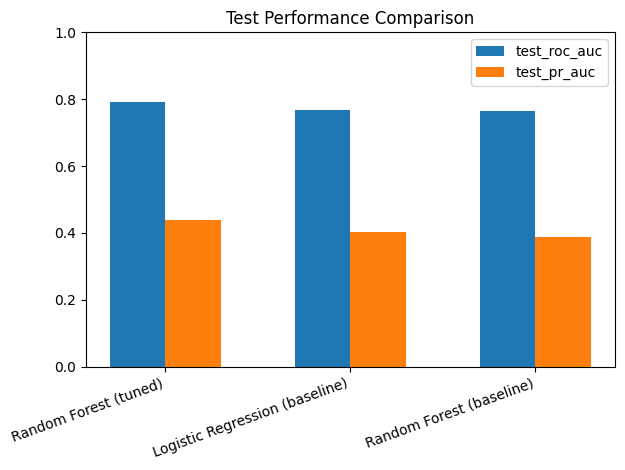

In [ ]:
# Optional: bar chart for TEST metrics
plt.figure()
x = np.arange(len(comparison_df_rounded))
plt.bar(x - 0.15, comparison_df_rounded["test_roc_auc"], width=0.3, label="test_roc_auc")
plt.bar(x + 0.15, comparison_df_rounded["test_pr_auc"],  width=0.3, label="test_pr_auc")
plt.xticks(x, comparison_df_rounded["model"], rotation=20, ha="right")
plt.ylim(0, 1)
plt.title("Test Performance Comparison")
plt.legend()
plt.tight_layout()
plt.show()

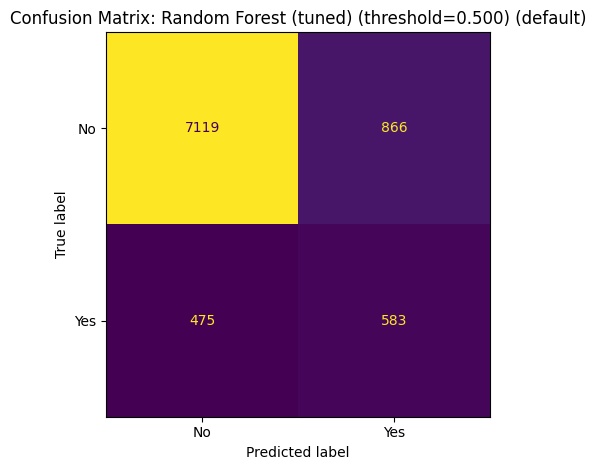

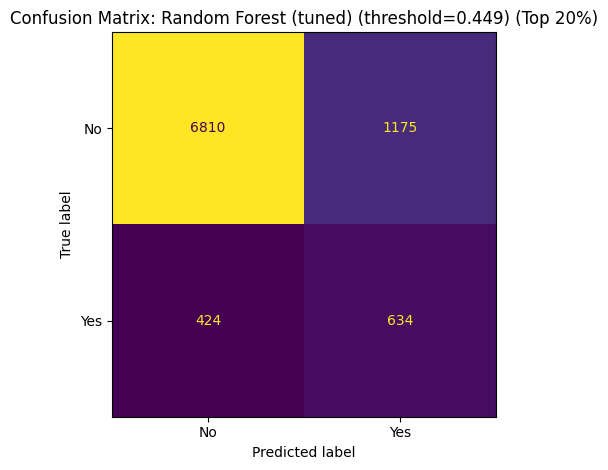

In [ ]:
# -----------------------------
# 2) Confusion Matrix (decision-relevant)
#    Show at two thresholds:
#      A) Default 0.5
#      B) Top-K threshold (capacity-based), e.g. call top 20%
# -----------------------------
def plot_confusion_for_threshold(model, model_name, threshold, title_suffix=""):
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No", "Yes"])

    fig, ax = plt.subplots()
    disp.plot(ax=ax, values_format="d", colorbar=False)
    ax.set_title(f"Confusion Matrix: {model_name} (threshold={threshold:.3f}) {title_suffix}")
    plt.tight_layout()
    plt.show()

# Choose a primary model for detailed evaluation (typically your selected model)
primary_model_name = "Random Forest (tuned)"
primary_model = models[primary_model_name]
primary_model.fit(X_train, y_train)

# A) Default threshold = 0.5
plot_confusion_for_threshold(primary_model, primary_model_name, threshold=0.5, title_suffix="(default)")

# B) Capacity-based threshold: call top K% (e.g., 20%)
K = 0.20
y_proba_primary = primary_model.predict_proba(X_test)[:, 1]
threshold_topk = np.quantile(y_proba_primary, 1 - K)  # threshold that selects top K proportion
plot_confusion_for_threshold(primary_model, primary_model_name, threshold=threshold_topk, title_suffix=f"(Top {int(K*100)}%)")


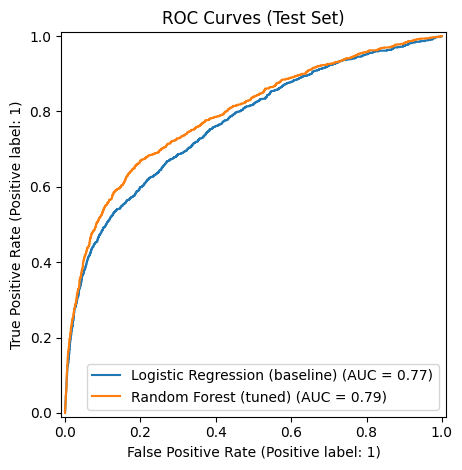

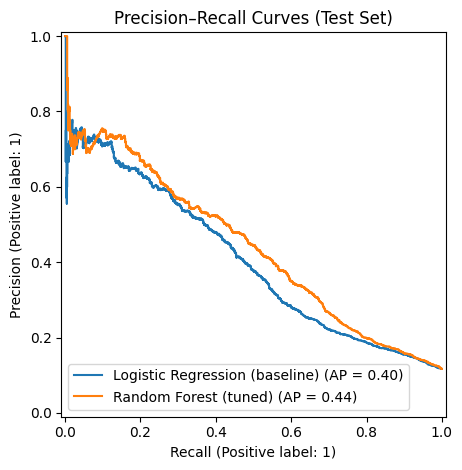

In [ ]:
# -----------------------------
# 3) ROC Curve + PR Curve (decision-relevant for imbalance)
# -----------------------------
# ROC

fig, ax = plt.subplots()
for name, model in models.items():
    model.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax, name=name)
ax.set_title("ROC Curves (Test Set)")
plt.tight_layout()
plt.show()

# PR
fig, ax = plt.subplots()
for name, model in models.items():
    model.fit(X_train, y_train)
    PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax, name=name)
ax.set_title("Precision–Recall Curves (Test Set)")
plt.tight_layout()
plt.show()


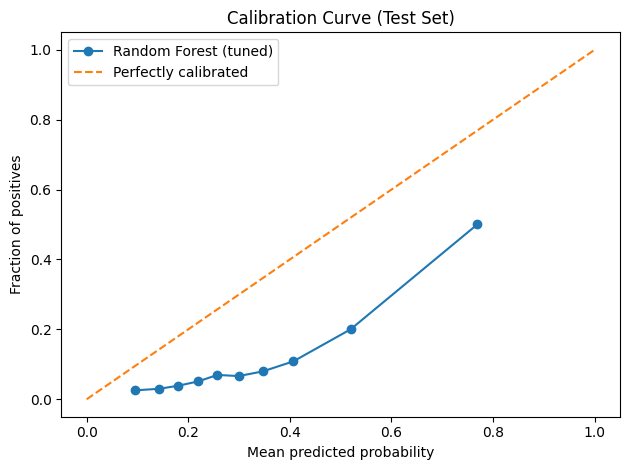

In [ ]:
# -----------------------------
# 4) Calibration curve (reliability of predicted probabilities)
#    Shows whether predicted probabilities match observed rates.
# -----------------------------

def plot_calibration(model, model_name, n_bins=10):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    frac_pos, mean_pred = calibration_curve(y_test, y_proba, n_bins=n_bins, strategy="quantile")

    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o", label=model_name)
    plt.plot([0, 1], [0, 1], linestyle="--", label="Perfectly calibrated")
    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.title("Calibration Curve (Test Set)")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_calibration(primary_model, primary_model_name, n_bins=10)


=== Top-K Business Evidence (Test Set) ===


,Model,Top %,Customers Called,Precision@K,Recall@K (Captured % of all subscribers),Lift@K (vs overall rate)
0,Logistic Regression (baseline),5,453,0.5938,0.2543,5.0755
1,Logistic Regression (baseline),10,905,0.4740,0.4055,4.0517
2,Logistic Regression (baseline),20,1809,0.3228,0.5520,2.7593
3,Logistic Regression (baseline),30,2713,0.2518,0.6456,2.1518
4,Random Forest (tuned),5,453,0.6071,0.2599,5.1887
5,Random Forest (tuned),10,905,0.5006,0.4282,4.2784
6,Random Forest (tuned),20,1809,0.3505,0.5992,2.9956
7,Random Forest (tuned),30,2713,0.2698,0.6919,2.3062


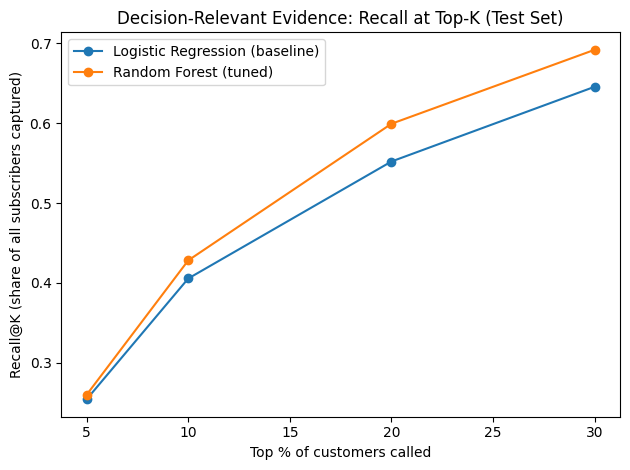

In [ ]:
# -----------------------------
# 5) Top-K business lift evidence (capacity-based)
#    Shows how many subscribers you capture by calling top K%.
# -----------------------------

def topk_table(model, model_name, ks=(0.05, 0.10, 0.20, 0.30)):
    model.fit(X_train, y_train)
    y_proba = model.predict_proba(X_test)[:, 1]

    df_eval = pd.DataFrame({"y_true": y_test.values, "proba": y_proba})
    df_eval = df_eval.sort_values("proba", ascending=False).reset_index(drop=True)

    total_pos = df_eval["y_true"].sum()
    base_rate = df_eval["y_true"].mean()

    out = []
    for k in ks:
        n = int(np.ceil(len(df_eval) * k))
        top = df_eval.iloc[:n]
        captured = top["y_true"].sum()
        recall_at_k = captured / total_pos if total_pos > 0 else np.nan
        precision_at_k = top["y_true"].mean()
        lift_at_k = precision_at_k / base_rate if base_rate > 0 else np.nan
        out.append({
            "Model": model_name,
            "Top %": int(k*100),
            "Customers Called": n,
            "Precision@K": precision_at_k,
            "Recall@K (Captured % of all subscribers)": recall_at_k,
            "Lift@K (vs overall rate)": lift_at_k
        })

    return pd.DataFrame(out)

topk_lr = topk_table(models["Logistic Regression (baseline)"], "Logistic Regression (baseline)")
topk_rf = topk_table(primary_model, primary_model_name)

topk_df = pd.concat([topk_lr, topk_rf], ignore_index=True)
print("\n=== Top-K Business Evidence (Test Set) ===")
display(topk_df.round(4))

# Optional: plot Recall@K curves (decision-relevant)
plt.figure()
for model_name in ["Logistic Regression (baseline)", primary_model_name]:
    temp = topk_df[topk_df["Model"] == model_name].sort_values("Top %")
    plt.plot(temp["Top %"], temp["Recall@K (Captured % of all subscribers)"], marker="o", label=model_name)
plt.xlabel("Top % of customers called")
plt.ylabel("Recall@K (share of all subscribers captured)")
plt.title("Decision-Relevant Evidence: Recall at Top-K (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()


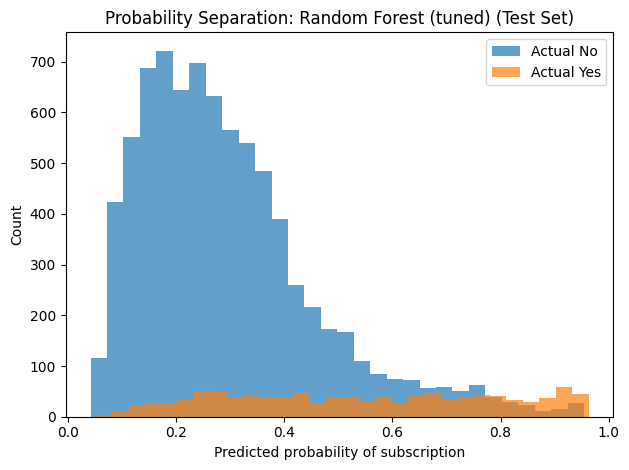

In [ ]:
# -----------------------------
# 6) (Optional) Probability distribution plot (separation evidence)
# -----------------------------

plt.figure()
plt.hist(y_proba_primary[y_test.values == 0], bins=30, alpha=0.7, label="Actual No")
plt.hist(y_proba_primary[y_test.values == 1], bins=30, alpha=0.7, label="Actual Yes")
plt.xlabel("Predicted probability of subscription")
plt.ylabel("Count")
plt.title(f"Probability Separation: {primary_model_name} (Test Set)")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# 7) Key limitations (write-up hints)
# -----------------------------

print("\n=== Key Limitations to State (for report) ===")
print("- Target is imbalanced (~11.7% 'yes'): PR-AUC and Top-K metrics are prioritised over accuracy.")
print("- 'duration' must be excluded to avoid leakage; results assume it is removed.")
print("- Results are based on one hold-out test split; consider repeated runs or repeated CV for extra robustness.")
print("- Threshold choice should reflect call capacity (Top-K) rather than default 0.5.")


=== Key Limitations to State (for report) ===
- Target is imbalanced (~11.7% 'yes'): PR-AUC and Top-K metrics are prioritised over accuracy.
- 'duration' must be excluded to avoid leakage; results assume it is removed.
- Results are based on one hold-out test split; consider repeated runs or repeated CV for extra robustness.
- Threshold choice should reflect call capacity (Top-K) rather than default 0.5.


#12. Deployment Justification & Practicality

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Selected deployment model
deploy_model_name = "Random Forest (tuned)"
deploy_model = rf_best  # tuned RF pipeline

# Call capacity (Top K%)
K = 0.20  # adjust to your scenario (e.g., 0.10, 0.15, 0.20)

# Fit model on training data (typical before deployment)
deploy_model.fit(X_train, y_train)

# Score the "deployment batch"
# Here we use X_test as a stand-in for new, unseen customers
scores = deploy_model.predict_proba(X_test)[:, 1]

In [ ]:
# -----------------------------
# 1) Generate a “Call List” Output (Ranked by Propensity)
# -----------------------------

call_list = X_test.copy()
call_list["propensity_score"] = scores

# OPTIONAL (for your own evaluation only; remove in real deployment)
call_list["y_true"] = y_test.values

# Threshold that selects Top K% highest-scoring customers
threshold_topk = np.quantile(call_list["propensity_score"], 1 - K)

# Action tier based on capacity
call_list["action_tier"] = np.where(
    call_list["propensity_score"] >= threshold_topk,
    "PRIORITY_CALL",
    "DEPRIORITISE"
)

# Rank by score (descending)
call_list = call_list.sort_values("propensity_score", ascending=False).reset_index(drop=True)

# Show what the call list looks like (top 20)
cols_preview = ["propensity_score", "action_tier"] + (["y_true"] if "y_true" in call_list.columns else [])
display(call_list[cols_preview].head(20))

,propensity_score,action_tier,y_true
0,0.962942,PRIORITY_CALL,1
1,0.961918,PRIORITY_CALL,1
2,0.959744,PRIORITY_CALL,1
3,0.959018,PRIORITY_CALL,1
4,0.955891,PRIORITY_CALL,1
5,0.955546,PRIORITY_CALL,1
6,0.954699,PRIORITY_CALL,0
7,0.952757,PRIORITY_CALL,1
8,0.951348,PRIORITY_CALL,1
9,0.951067,PRIORITY_CALL,0


In [ ]:
# Deliverable for real life: export as CSV to hand over to call centre.

# Export for ops use (remove y_true in real deployment)
call_list.drop(columns=["y_true"]).to_csv("call_list_topk.csv", index=False)

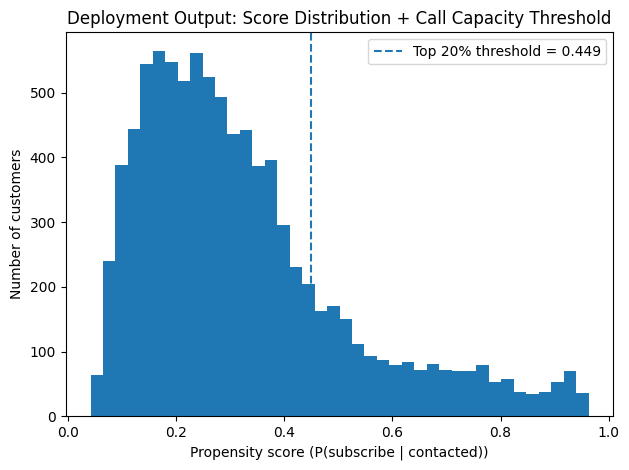

In [ ]:
# -----------------------------
# 2) Score Distribution + Capacity Threshold (Decision Practicality)
# -----------------------------

plt.figure()
plt.hist(call_list["propensity_score"], bins=40)
plt.axvline(threshold_topk, linestyle="--", label=f"Top {int(K*100)}% threshold = {threshold_topk:.3f}")
plt.xlabel("Propensity score (P(subscribe | contacted))")
plt.ylabel("Number of customers")
plt.title("Deployment Output: Score Distribution + Call Capacity Threshold")
plt.legend()
plt.tight_layout()
plt.show()

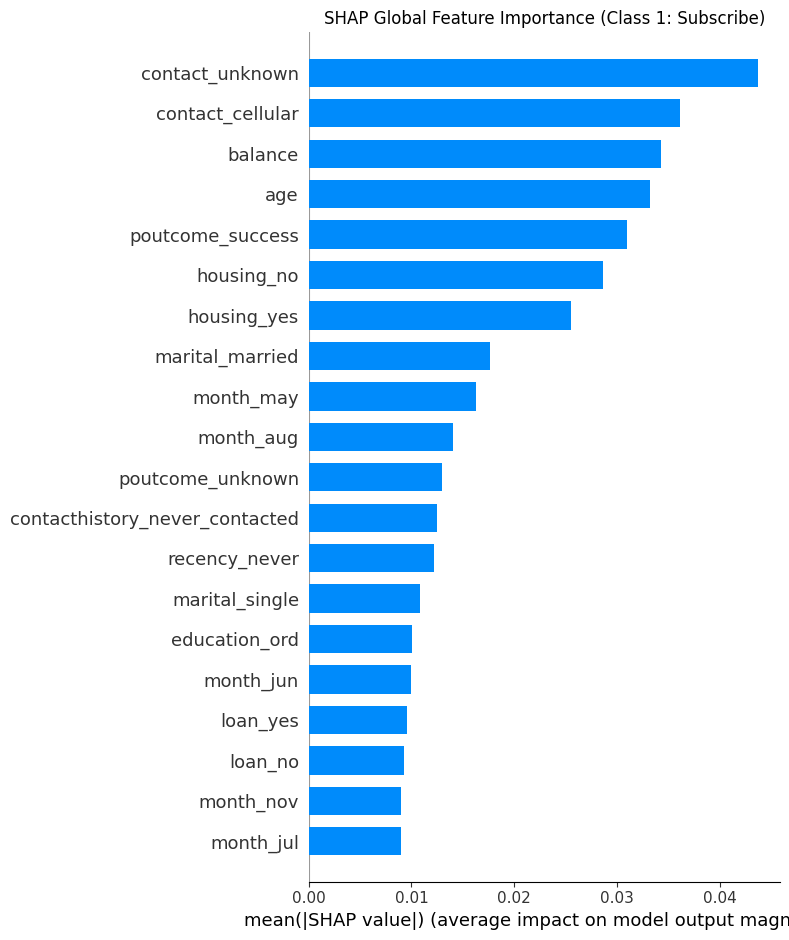

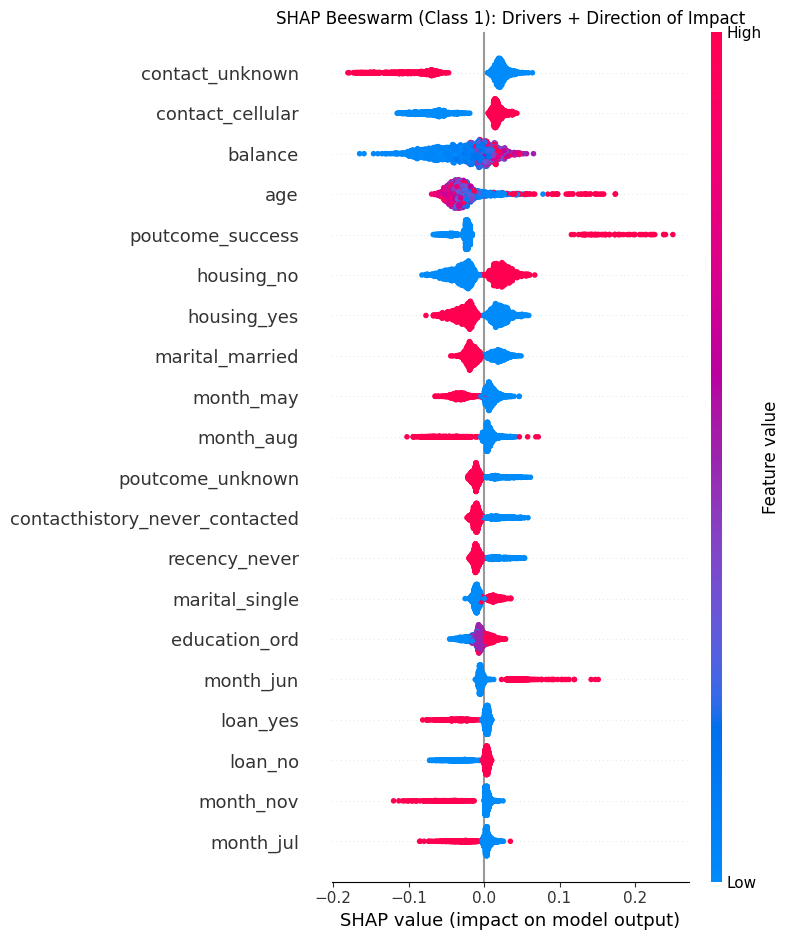

In [ ]:
# -----------------------------
# 3) SHAP Beeswarm plot + SHAP bar summary plot (Global drivers)
# -----------------------------

import shap

# Use a manageable sample for SHAP (speed)
X_shap = X_test.sample(n=min(2000, len(X_test)), random_state=42)

# Extract the RandomForestClassifier from the pipeline
# (Works if rf_best is a Pipeline with step name "model")
rf_clf = deploy_model.named_steps["model"] if hasattr(deploy_model, "named_steps") else deploy_model["model"]

explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_shap)

# Robustly select class 1 ("Yes") SHAP values across shap versions
if isinstance(shap_values, np.ndarray) and shap_values.ndim == 3:
    shap_vals_pos = shap_values[:, :, 1]
elif isinstance(shap_values, list):
    shap_vals_pos = shap_values[1]
else:
    shap_vals_pos = shap_values

# (A) SHAP bar summary: global importance (mean |SHAP|)
shap.summary_plot(shap_vals_pos, X_shap, plot_type="bar", show=False)
plt.title("SHAP Global Feature Importance (Class 1: Subscribe)")
plt.tight_layout()
plt.show()

# (B) SHAP beeswarm: global + direction (high/low feature values)
shap.summary_plot(shap_vals_pos, X_shap, show=False)
plt.title("SHAP Beeswarm (Class 1): Drivers + Direction of Impact")
plt.tight_layout()
plt.show()

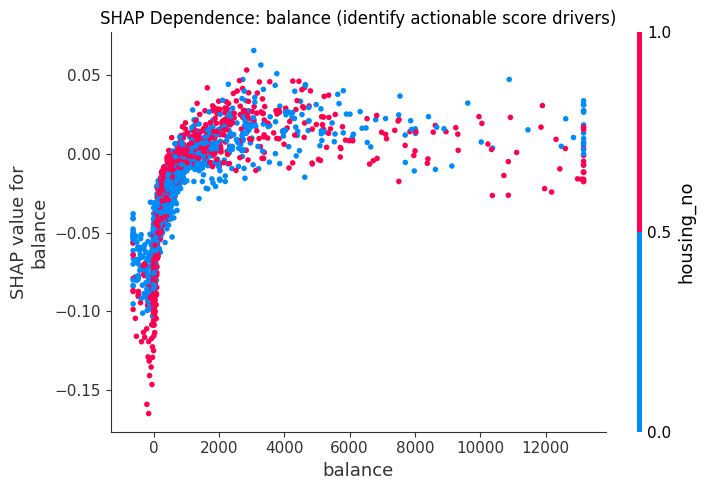

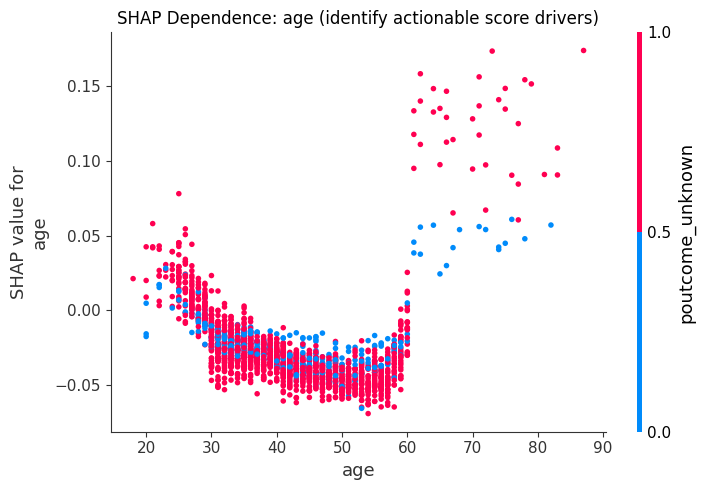

In [ ]:
# -----------------------------
# 4) SHAP Dependence plots on balance and age (Triggers)
# -----------------------------

# Dependence plot: balance
feature = "balance"
if feature in X_shap.columns:
    shap.dependence_plot(feature, shap_vals_pos, X_shap, show=False)
    plt.title("SHAP Dependence: balance (identify actionable score drivers)")
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature '{feature}' not found in X_shap columns.")

# Dependence plot: age
feature = "age"
if feature in X_shap.columns:
    shap.dependence_plot(feature, shap_vals_pos, X_shap, show=False)
    plt.title("SHAP Dependence: age (identify actionable score drivers)")
    plt.tight_layout()
    plt.show()
else:
    print(f"Feature '{feature}' not found in X_shap columns.")

,feature,psi
0,age,0.001807
1,balance,0.000566


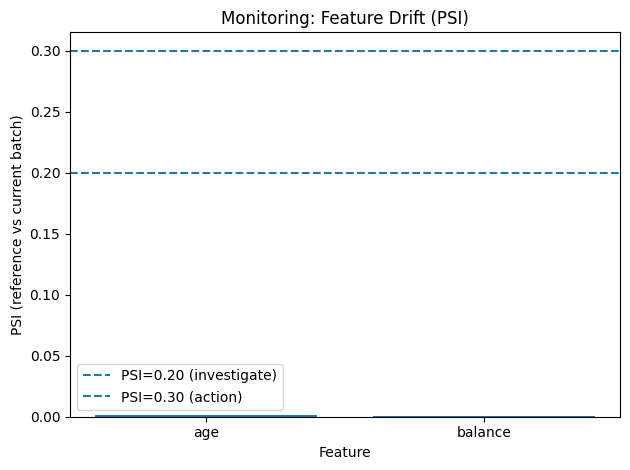

In [ ]:
# -----------------------------
# 5) Monitoring: PSI Bar Chart (Feature drift)
# -----------------------------

def psi(expected, actual, bins=10):
    expected = np.asarray(expected)
    actual = np.asarray(actual)

    # Bin edges from expected distribution
    edges = np.quantile(expected, np.linspace(0, 1, bins + 1))
    edges[0] = -np.inf
    edges[-1] = np.inf

    exp_counts, _ = np.histogram(expected, bins=edges)
    act_counts, _ = np.histogram(actual, bins=edges)

    exp_perc = exp_counts / max(exp_counts.sum(), 1)
    act_perc = act_counts / max(act_counts.sum(), 1)

    eps = 1e-6
    exp_perc = np.clip(exp_perc, eps, None)
    act_perc = np.clip(act_perc, eps, None)

    return float(np.sum((act_perc - exp_perc) * np.log(act_perc / exp_perc)))

# Choose a small set of key numeric features you actually have
psi_features = [c for c in ["age", "balance"] if c in X_train.columns]

psi_vals = [psi(X_train[c], X_test[c], bins=10) for c in psi_features]
psi_df = pd.DataFrame({"feature": psi_features, "psi": psi_vals}).sort_values("psi", ascending=False)

display(psi_df)

plt.figure()
plt.bar(psi_df["feature"], psi_df["psi"])
plt.axhline(0.2, linestyle="--", label="PSI=0.20 (investigate)")
plt.axhline(0.3, linestyle="--", label="PSI=0.30 (action)")
plt.xlabel("Feature")
plt.ylabel("PSI (reference vs current batch)")
plt.title("Monitoring: Feature Drift (PSI)")
plt.legend()
plt.tight_layout()
plt.show()

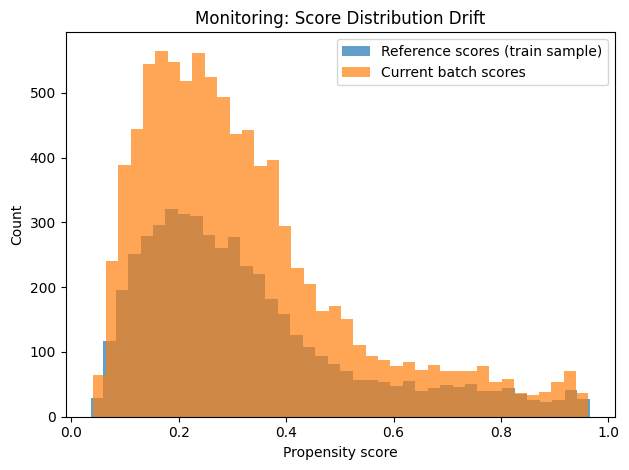

In [ ]:
# -----------------------------
# 6) Monitoring: Score Drift (Output drift)
# -----------------------------

# Reference scores: use a sample from training for speed
train_sample = X_train.sample(n=min(5000, len(X_train)), random_state=42)
scores_ref = deploy_model.predict_proba(train_sample)[:, 1]

# Current batch scores (proxy): scores from X_test
scores_current = scores

plt.figure()
plt.hist(scores_ref, bins=40, alpha=0.7, label="Reference scores (train sample)")
plt.hist(scores_current, bins=40, alpha=0.7, label="Current batch scores")
plt.xlabel("Propensity score")
plt.ylabel("Count")
plt.title("Monitoring: Score Distribution Drift")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# -----------------------------
# 7A) Pick a strong example (highest score in PRIORITY_CALL)
# -----------------------------

import numpy as np
import shap
import matplotlib.pyplot as plt

# 1) Fit model
rf_best.fit(X_train, y_train)

# 2) Get scores on X_test (scores is aligned with X_test.index)
scores = rf_best.predict_proba(X_test)[:, 1]
scores_s = pd.Series(scores, index=X_test.index, name="propensity_score")

# 3) Compute Top-K threshold
K = 0.20
threshold_topk = scores_s.quantile(1 - K)

# 4) Pick the HIGHEST score inside the Top-K group
priority_indices = scores_s[scores_s >= threshold_topk].index
top_idx = scores_s.loc[priority_indices].idxmax()

print("Top-K threshold:", float(threshold_topk))
print("Selected top_idx:", top_idx)
print("Selected propensity score:", float(scores_s.loc[top_idx]))

# 5) Get the exact row to explain
sample = X_test.loc[[top_idx]]

Top-K threshold: 0.44910394326638425
Selected top_idx: 42585
Selected propensity score: 0.9629418357687217


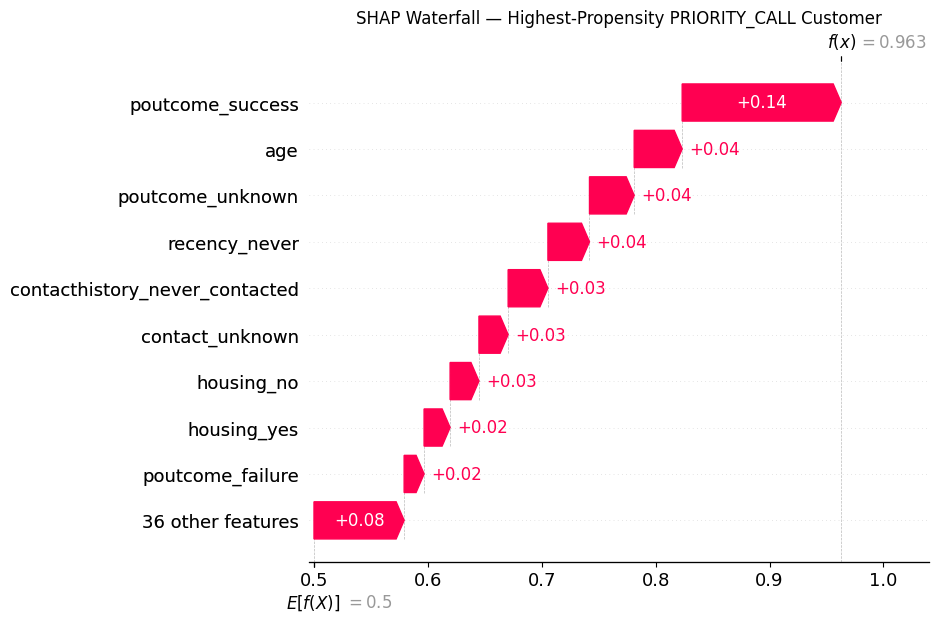

In [ ]:
# Extract RF estimator from the pipeline
rf_clf = rf_best.named_steps["model"]  # assumes step name is "model"

explainer = shap.TreeExplainer(rf_clf)
shap_values_single = explainer.shap_values(sample)

# Robust extraction for class 1
if isinstance(shap_values_single, list):
    shap_single = shap_values_single[1][0]  # (n_features,)
    expected_value = explainer.expected_value[1]
elif isinstance(shap_values_single, np.ndarray) and shap_values_single.ndim == 3:
    shap_single = shap_values_single[0, :, 1]
    expected_value = explainer.expected_value[1]
else:
    shap_single = shap_values_single[0] if shap_values_single.ndim == 2 else shap_values_single
    expected_value = explainer.expected_value

plt.title("SHAP Waterfall — Highest-Propensity PRIORITY_CALL Customer")

# Plot
shap.plots._waterfall.waterfall_legacy(
    expected_value,
    shap_single,
    feature_names=sample.columns,
    max_display=10
)
#plt.title("SHAP Waterfall — Highest-Propensity PRIORITY_CALL Customer")
#plt.tight_layout()
#plt.show()